Import requirements

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
import nocd
torch.set_default_tensor_type(torch.FloatTensor)

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `scipy.sparse.csr_matrix` of size `[N, D]`
 - `Z_gt` (binary community affiliation matrix) is a `np.ndarray` of size `[N, K]`


 N : number of samples , 
 K: number of communities

In [17]:
loader = nocd.data.load_dataset('data/fb_686.npz')
A, X, Z_gt = loader['A'], loader['X'], loader['Z']
N, K = Z_gt.shape

Define the hyperparameters

In [18]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 1000        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

In [19]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm)

Normalize input

In [20]:
from nocd.utils import to_sparse_tensor
def normalize_adj(adj : sp.csr_matrix):
    if sp.isspmatrix(adj):
        adj = adj.tolil()
        adj.setdiag(1)
        adj = adj.tocsr()
        deg = np.ravel(adj.sum(1))
        deg_sqrt_inv = 1 / np.sqrt(deg)
        adj_norm = adj.multiply(deg_sqrt_inv[:, None]).multiply(deg_sqrt_inv[None, :])
    elif torch.is_tensor(adj):
        deg = adj.sum(1)
        deg_sqrt_inv = 1 / torch.sqrt(deg)
        adj_norm = adj * deg_sqrt_inv[:, None] * deg_sqrt_inv[None, :]
    return to_sparse_tensor(adj_norm)

Define the GNN model

In [21]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout)
#gnn = nocd.nn.ImprovedGCN(x_norm.shape[1], hidden_sizes, K, layer_norm=batch_norm, dropout=dropout)
adj_norm =normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

Get NMI 

In [22]:
def get_nmi(thresh=0.5):
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

Training loop

In [31]:
val_loss = np.inf
validation_fn = lambda: val_loss

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch %50 == 0:
        with torch.no_grad():
            gnn.eval()

            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Epoch    0, loss.full = 0.3281, nmi = 0.21
Epoch   50, loss.full = 0.3200, nmi = 0.18
Epoch  100, loss.full = 0.3178, nmi = 0.19
Epoch  150, loss.full = 0.3173, nmi = 0.20
Epoch  200, loss.full = 0.3161, nmi = 0.18
Epoch  250, loss.full = 0.3212, nmi = 0.20
Epoch  300, loss.full = 0.3250, nmi = 0.19
Epoch  350, loss.full = 0.3118, nmi = 0.19
Epoch  400, loss.full = 0.3169, nmi = 0.18
Epoch  450, loss.full = 0.3243, nmi = 0.21
Epoch  500, loss.full = 0.3199, nmi = 0.21
Epoch  550, loss.full = 0.3226, nmi = 0.20
Epoch  600, loss.full = 0.3181, nmi = 0.19
Epoch  650, loss.full = 0.3226, nmi = 0.20
Epoch  700, loss.full = 0.3144, nmi = 0.19
Epoch  750, loss.full = 0.3227, nmi = 0.20
Epoch  800, loss.full = 0.3180, nmi = 0.19
Epoch  850, loss.full = 0.3162, nmi = 0.20
Epoch  900, loss.full = 0.3294, nmi = 0.21
Epoch  950, loss.full = 0.3152, nmi = 0.19
Epoch 1000, loss.full = 0.3202, nmi = 0.19


Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

In [32]:
thresh = 0.5

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh

print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.195


Visualize the adjacency matrix sorted by the communities

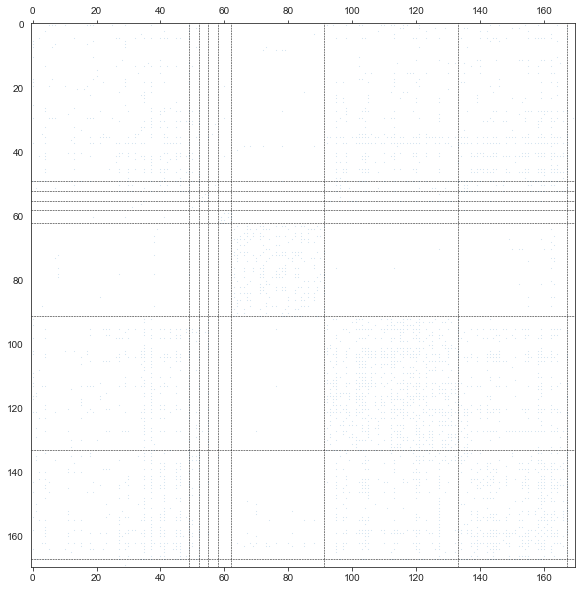

In [25]:

plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [26]:
# Print Sizes of detected communities
print(Z_pred.sum(0))

[14 11  2  3  3  4  0  0 29 47  0 56  2 32]
